# Overall Description

In [ ]:
# This is an 3D example code based on SimPEG package.
# All cases are designed for on-land survey using 
# feequency domain CSEM method, with a line source.

# Author: Zhuo Liu, Colorado School of Mines
# Created in May, 2020

# Import Packages

In [1]:
# Import package

import math as m
import numpy as np
import SimPEG as spg
#from SimPEG import EM, Utils
from discretize import TreeMesh, TensorMesh
from SimPEG.utils  import ExtractCoreMesh
import SimPEG.electromagnetics.frequency_domain as FDEM
from discretize.utils import refine_tree_xyz
import pyvista as pv
from pymatsolver import Pardiso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Define Functions

In [17]:
# Self defined fucntions, for a succinct code and versatility

# Define function to construct anomalous bodies
def SinglebodyTensorMesh3D(core_x, core_y, core_z, core_hx, core_hy, core_hz, 
                           npadx, npady, npadz, pad_factor
                          ):
    '''
    Input: core_x/ core_y/ core_y: The length of core region in 3 directions in meter, int;
           core_hx/ core_hy/ core_hz: Cell widths in the core region of the mesh in meter, int;
           npadx/ npady/ npadz: Number of padding cells in each dimension;
           pad_factor: Padding factor
    
    Output: mesh: tensor mesh, with single densily-meshed region
    '''
    
    # Calculate the number of cells in core region
    n_core_x, n_core_y, n_core_z = int(core_x/core_hx), int(core_y/core_hy), int(core_z/core_hz)
    
    # Make meshed space
    mesh = TensorMesh([
        [(core_hx, npadx, -pad_factor), (core_hx, n_core_x), (core_hx, npadx, pad_factor)],
        [(core_hy, npady, -pad_factor), (core_hy, n_core_y), (core_hy, npady, pad_factor)],
        [(core_hz, npadz, -pad_factor), (core_hz, n_core_z), (core_hz, npadz, pad_factor)]
    ])
     
    return mesh


# Define function to construct anomalous bodies
def MultibodyTreeMesh3D(basemesh, x_bound, y_bound, z_bound, methods, tree_level):
    '''
    Input: basemesh: The basemesh need to be refined, SimPEG.Mesh;
           x_bound: Boundary of each region in x-direction, 1D array or list.
                    organized as [x1start, x1end, x2start, x2end...]
           y_bound: Boundary of each region in y-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           z_bound: Boundary of each region in z-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           methods: Method to refine mesh.
           tree_level: 
    
    Output: mesh: Tree mesh with multiple anomalous region, mesh
    '''
    
    if len(x_bound) == len(y_bound) == len(z_bound):

        nbody = int(len(x_bound)/2)

        for n in range(nbody):
            # Construct vectors of all vertices for nth anomalous body
            xyz = spg.utils.ndgrid([np.r_[x_bound[2*n],x_bound[2*n+1]], 
                                    np.r_[y_bound[2*n],y_bound[2*n+1]], 
                                    np.r_[z_bound[2*n],z_bound[2*n+1]]])    # Extrate vertices for nth anomalous body

            # Discretize to finest cell size within rectangular box
            mesh = refine_tree_xyz(basemesh, xyz, 
                                   octree_levels=[tree_level[3*n], tree_level[3*n+1], tree_level[3*n+2]],
                                   #octree_levels_padding = [5, 5, 5]
                                   method=methods[n], 
                                   finalize=False
                                  )

        mesh.finalize()
    
    else:
        raise Exception('length of x_bound, y_bound, and z_bound should be same')
    
    return mesh


# Define function to fill the mesh with physical property values
def ModelConstruct3D(mesh, physivalue, x_bound, y_bound, z_bound):
    '''
    Input: mesh: The mesh created for modeling, SimPEG.Mesh;
           physivalue: Physical property values, 1D array;
           x_bound: Boundary of each region in x-direction, 1D array or list.
                    organized as [x1start, x1end, x2start, x2end...]
           y_bound: Boundary of each region in y-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           z_bound: Boundary of each region in z-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
    
    Tip: 1. All inputs should be organized in an order from large-region to small-region;
         2. All bound values should be organized in an order from lower value to highre value.
    
    Output: model: the model, array
    '''
    
    nvalue = len(physivalue)
    
    model = np.ones(mesh.nC)    # Initialize model vector
    
    for i in range(nvalue):
        index = (
            (mesh.gridCC[:, 0]>=x_bound[2*i]) & (mesh.gridCC[:, 0]<=x_bound[2*i+1]) &
            (mesh.gridCC[:, 1]>=y_bound[2*i]) & (mesh.gridCC[:, 1]<=y_bound[2*i+1]) &
            (mesh.gridCC[:, 2]>=z_bound[2*i]) & (mesh.gridCC[:, 2]<=z_bound[2*i+1])
        )

        model[index] = physivalue[i]    #Set rock-background

    return model


# Define function to calculate skin septh
def Skin_Depth(sigma_list, freq_list):
    sigma = np.unique(sigma_list)
    freq = np.unique(freq_list)
    skin_depth = []
    for f in freq:
        for s in sigma:
            skin_depth.append(500./np.sqrt(s * f))
    
    return skin_depth



# Mesh Model Space and Forward Model

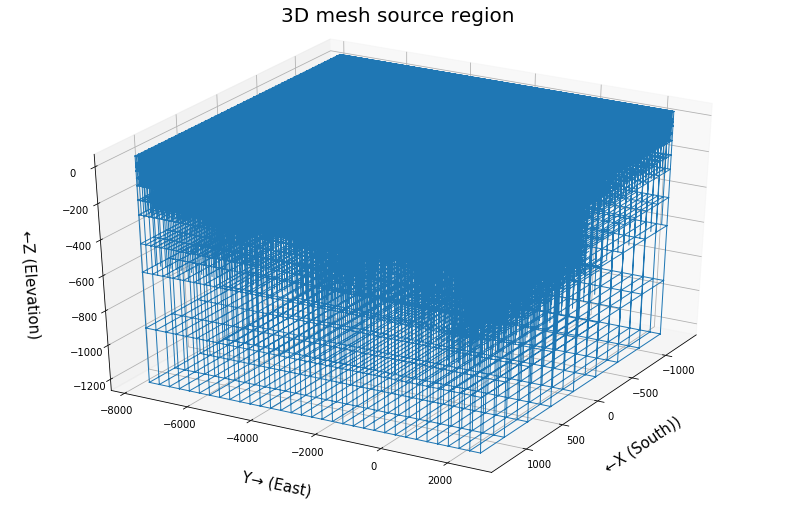

There are 209148 cells in the mesh


In [3]:
# Set model space and value with tree mesh

#Set the minimum cell size in each direction
base_dx, base_dy, base_dz = 20, 20, 20

# Set the number of the whole-model-space base cell in each dirction
nbc_x, nbc_y, nbc_z = 128, 512, 64

# Define the base mesh
hx = base_dx*np.ones(nbc_x)
hy = base_dy*np.ones(nbc_y)
hz = base_dz*np.ones(nbc_z)
basemesh = TreeMesh([hx, hy, hz],)

# Shift the center of model space
basemesh.x0 = np.r_[
    -(basemesh.hx.sum()*0.5),    # Shift 0-position in X direction
    -(basemesh.hy.sum()*0.75),    # Shift 0-position in Y direction
    -(basemesh.hz[0:nbc_z-2].sum())    # Set zero in z-direction below 15 layer of base mesh cells
    ]

# Set region for different mesh densities
# Normally these regions are slightly larger than the source region
x_bound=[-(basemesh.hx.sum()*0.5), (basemesh.hx.sum()*0.5),
         -600, -200,    # Anomalous area
         200, 600
         ] 
y_bound=[-(basemesh.hy.sum()*0.75), (basemesh.hy.sum()*0.25),
         800, 1200,
         800, 1200
        ] 
z_bound=[0, 0,
         -600, -200, 
         -600, -200
         ]

methods = ['surface', 'box', 'box']    # Method to refine mesh
tree_level = [1,1,1, 1,1,1, 1,1,1]    # Level of refinment

mesh = MultibodyTreeMesh3D(basemesh, x_bound, y_bound, z_bound, methods, tree_level)


# Plot the mesh and print the number of cells
Mesh_fig = plt.figure(1, figsize=(16,9))
Mesh_plot = mesh.plotGrid()
plt.title('3D mesh source region\n', fontsize=20, loc='center')
Mesh_plot.set_xlabel('\n\n\n ←X (South))', fontsize=15)
Mesh_plot.set_ylabel('\n\n\n Y→ (East)', fontsize=15)
Mesh_plot.set_zlabel('\n\n\n ←Z (Elevation)', fontsize=15)
Mesh_plot.view_init(32, 30)    # Set view angle, make it clear that we use right-handed coordinate system.
plt.show()
print(f"There are {mesh.nC} cells in the mesh")



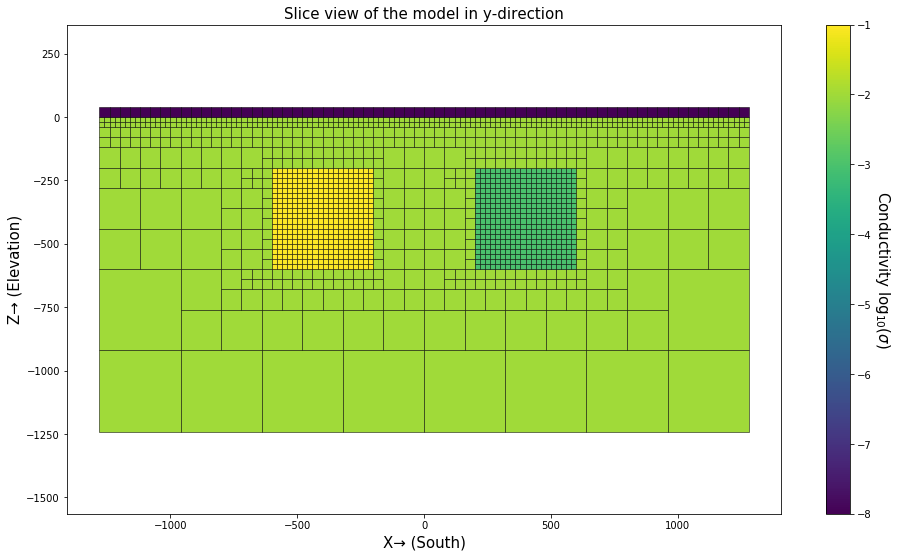

In [14]:
# Incorporate model value into the mesh
sigma_list = np.r_[1e-8, 0.01, 0.1, 0.001]    # Conductivity for air whole space, host-rock half space, and anomalous block

# Section below is one example to set different region for physical values for tree mesh.
# Folloing code can be applied directly

# Set the region for different mode lvalues
x_bound_source=[mesh.gridFx.min(), mesh.gridFx.max(),    # Air layer
                mesh.gridFx.min(), mesh.gridFx.max(),    # Host rock
                -600, -200,    # Conductive block 
                200, 600        
               ]
y_bound_source=[mesh.gridFy.min(), mesh.gridFy.max(),
                mesh.gridFy.min(), mesh.gridFy.max(),
                800, 1200,
                800, 1200
               ] 
z_bound_source=[0, mesh.gridFz.max(),
                mesh.gridFz.min(), 0,
                -600, -200,
                -600, -200
               ]

# Fill the meshed space with model values
sigma = ModelConstruct3D(mesh, sigma_list, x_bound_source, y_bound_source, z_bound_source)    # Fill model values to the mesh

# Plot the model, slice view
slicenorm = 'y'

Model_fig = plt.figure(2, figsize=(16,9))
Model_plot = plt.subplot(111)
if slicenorm == 'y':
    slice_position = 440
    Filled_model = mesh.plotSlice(np.log10(sigma), 
                              normal=slicenorm, ind=slice_position, 
                              ax=Model_plot,
                              grid=True)
    plt.title('Slice view of the model in y-direction', fontsize=15)
    plt.xlabel('X→ (South)', fontsize=15)
if slicenorm == 'x':
    slice_position = int(-basemesh.x0[0]/base_dx)
    filled_model = mesh.plotSlice(np.log10(sigma), 
                              normal=slicenorm, ind=slice_position, 
                              ax=Model_plot,
                              grid=True)
    plt.title('Slice view of the model in x-direction', fontsize=15)
    plt.xlabel('Y→ (East)', fontsize=15)
plt.ylabel('Z→ (Elevation)', fontsize=15)
plt.axis('equal')
bar2 = plt.colorbar(Filled_model[0])
bar2.set_label(label='Conductivity $\log_{10}(\\sigma)$', fontsize=15, rotation=270, labelpad=20)
plt.show()


# Setup Survey

In [38]:
# Set up survey geometry

# Source parameters
# For line source, use solenoid to approximate. Place solenoid on the cell edge.
src_x_lim = [-500, 500]
src_loc_x = mesh.vectorNx[(mesh.vectorNx>=src_x_lim[0]) & (mesh.vectorNx<=src_x_lim[1])]    # Station location in x-direction
src_loc_y = np.r_[-6000]    # Station location in y-direction
src_loc_z = np.r_[0]    # Station location in z-direction
freq_list = np.r_[0.25, 0.75, 1, 5, 
                  10, 15, 20, 30, 
                  50, 100, 500, 1000]    # Source frequency in Hz

src_locs = spg.utils.ndgrid([src_loc_x, src_loc_y, src_loc_z])    # Sourrce coordinates
src_index = spg.utils.closestPoints(mesh, src_locs)[1:]    # [1:] is needed to drop the first point outside of the ssrc_x_lim
src_vec_x = np.zeros(mesh.nEx)
src_vec_y = np.zeros(mesh.nEy)
src_vec_z = np.zeros(mesh.nEz)
src_vec_x[src_index] = 100    # Source vector, number is intensity
src_vec = np.hstack((src_vec_x, src_vec_y, src_vec_z))

# Receiver parameters
rx_loc_x = np.linspace(-1000,1000, 21)
rx_loc_y = np.linspace(0,2000, 11)
rx_loc_z = np.r_[0]
rx_locs = spg.utils.ndgrid(rx_loc_x, rx_loc_y, rx_loc_z)    # Receiver coordinates

# Set up the survey problem fir Electric field/data (E, with EB formulation)
rx_e_real = FDEM.receivers.PointElectricField(rx_locs, orientation="x",component='real')
rx_e_imag = FDEM.receivers.PointElectricField(rx_locs, orientation="x",component='imag')
rx_e = [rx_e_real, rx_e_imag]

# Calculate skin depth
skin_depth = Skin_Depth(sigma_list, freq_list)


Skin depths is between 50.0m and 10000000.0m


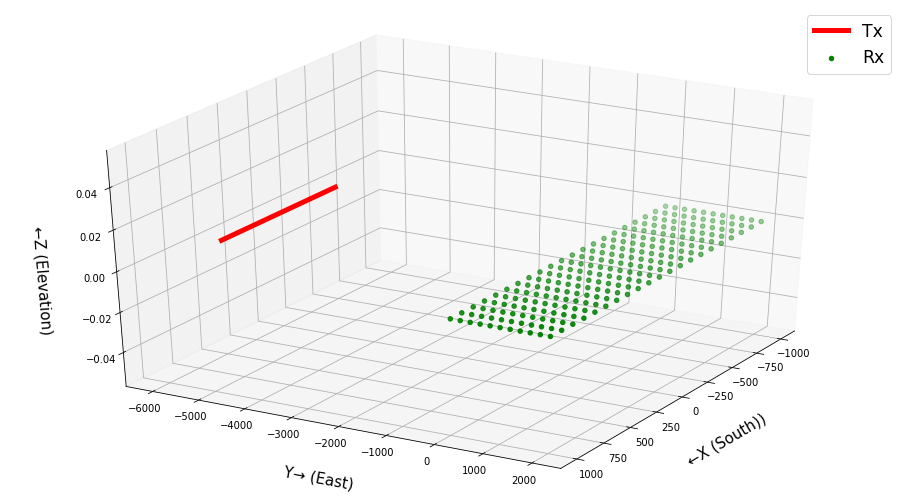

In [39]:
# Plot the survey
srx_x = src_x_lim
src_y = np.r_[src_loc_y, src_loc_y]
src_z = np.r_[src_loc_z, src_loc_z]
Survey_fig = plt.figure(3, figsize=(16,9))
Survey_plot = plt.subplot(111, projection='3d')
Survey_plot.plot(srx_x, src_y, src_z, c='red', linewidth=5, label='Tx')
Survey_plot.scatter(rx_locs[:,0], rx_locs[:,1], rx_locs[:,2], c='green', label='Rx')
Survey_plot.set_xlabel('\n\n\n ←X (South))', fontsize=15)
Survey_plot.set_ylabel('\n\n\n Y→ (East)', fontsize=15)
Survey_plot.set_zlabel('\n\n\n ←Z (Elevation)', fontsize=15)
Survey_plot.view_init(32, 30)    # Set view angle, make it clear that we use right-handed coordinate system.
Survey_plot.legend(fontsize='xx-large')
print('Skin depths is between ' + 
      str(round(min(skin_depth),2))+ 'm and ' 
      + str(round(max(skin_depth),2)) + 'm')
plt.show()


# Calculate EM Data

In [40]:
# Set up survey and problem pair, and calculate response
freq_count = 0
e_data = np.zeros((len(freq_list), 2*len(rx_locs)))    # Create array to store data
for freq in freq_list:
    srcList_e = [FDEM.sources.RawVec_e(rx_e, freq, src_vec)]    # Approximation of line source. Will change

    # Define EM problem for E measurement
    survey_e = FDEM.Survey(srcList_e)
    simulation_e = FDEM.simulation.Simulation3DElectricField(mesh, sigmaMap = spg.maps.IdentityMap(mesh),
                                                         survey=survey_e,
                                                         Solver=Pardiso, verbose=True)

    # Pair the physics and survey
    simulation_e.pair(survey_e)
    
    # Calculate electric data data
    e_data[freq_count, :] = simulation_e.dpred(sigma)    # Electric data
    
    freq_count += 1
    print('freq_count is ' + str(freq_count))

# Separate real and imaginary parts
e_data_real = e_data[:,0:len(rx_locs)]    # Electric field data
e_data_imag = e_data[:,len(rx_locs):]

# Calculate data amplitude and phase
e_amp = np.sqrt(e_data_real**2 + e_data_imag**2)    # Electric 
e_phase = np.arctan2(e_data_imag, e_data_real)

freq_count is 1
freq_count is 2
freq_count is 3
freq_count is 4
freq_count is 5
freq_count is 6
freq_count is 7
freq_count is 8
freq_count is 9
freq_count is 10
freq_count is 11
freq_count is 12


# Plot results

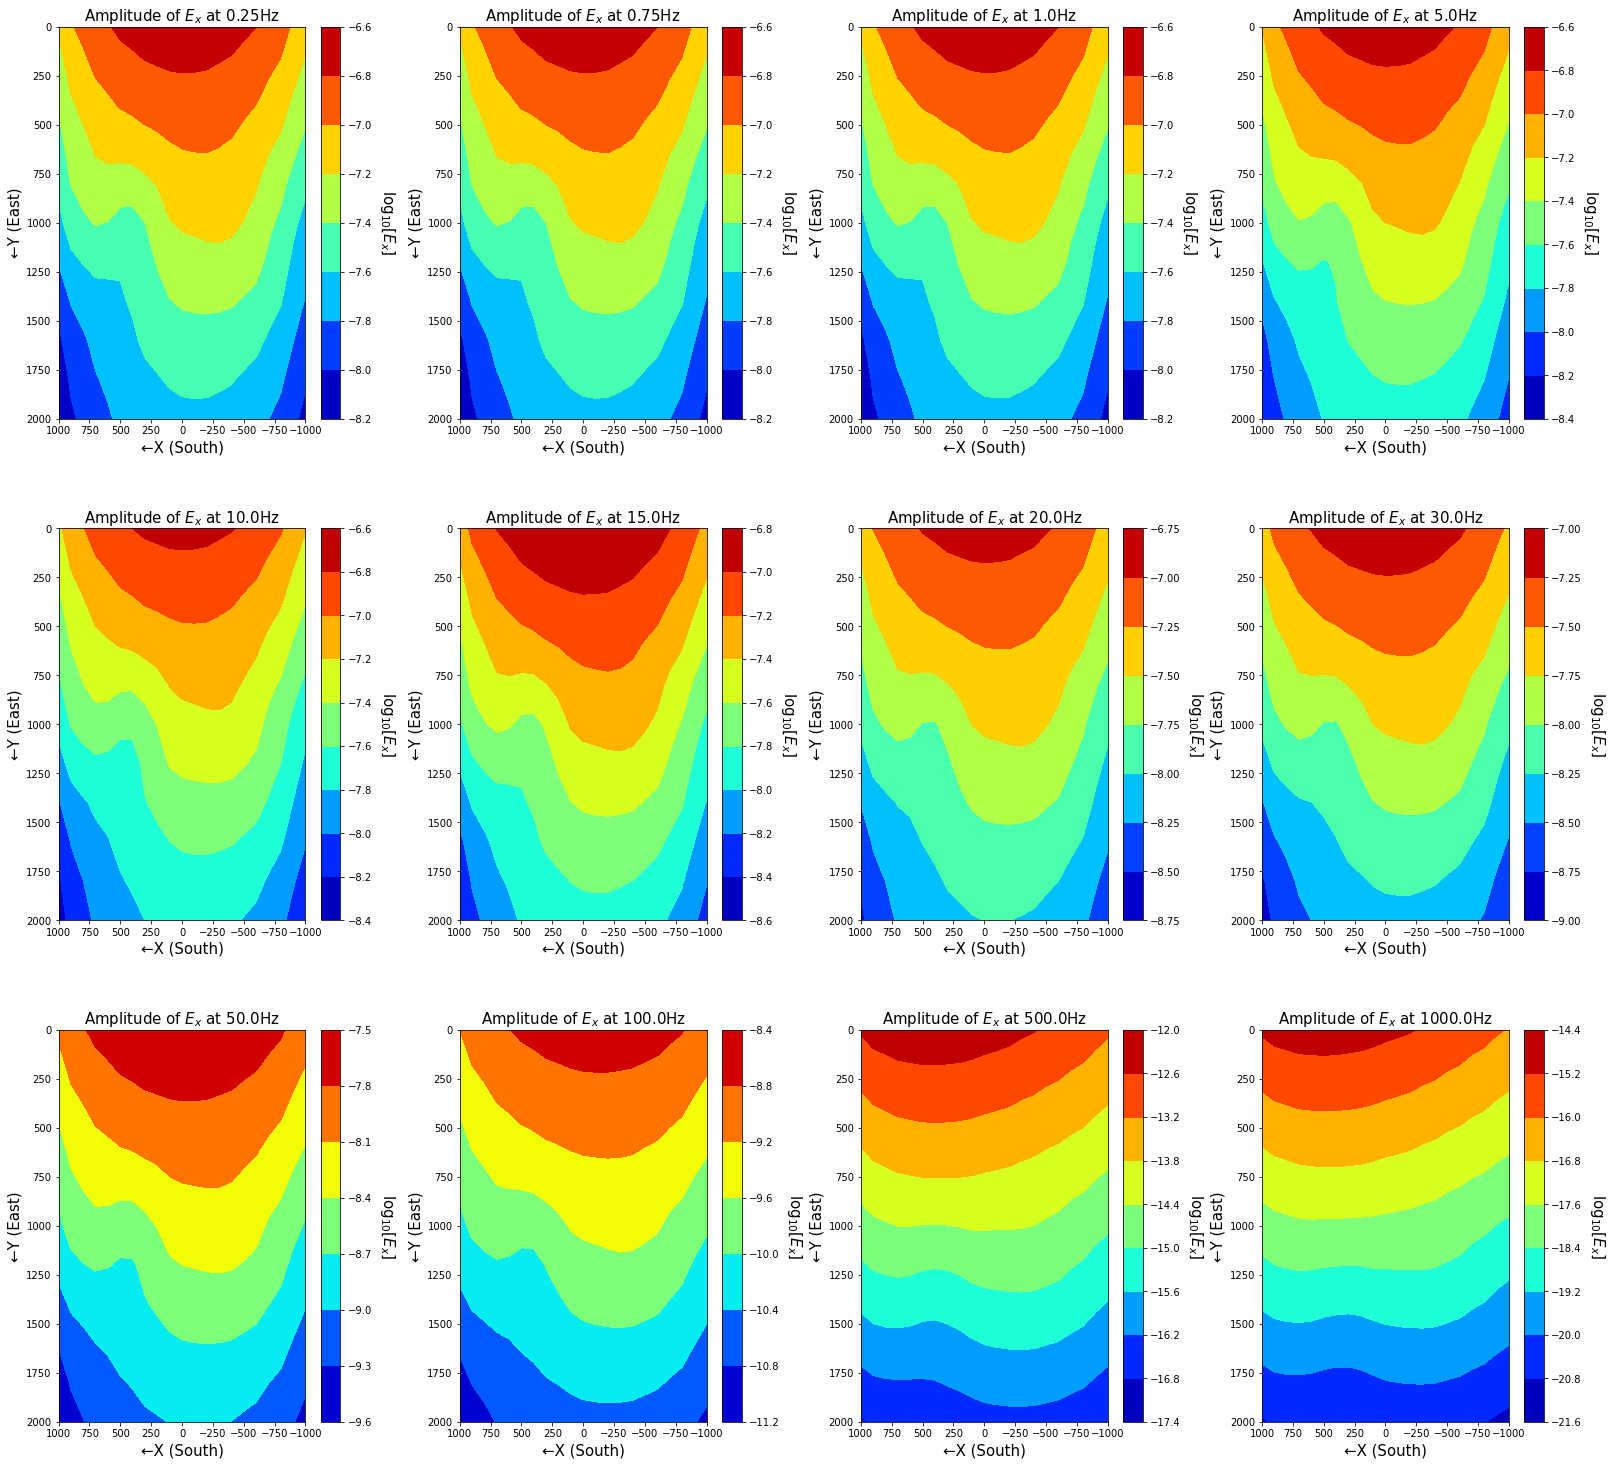

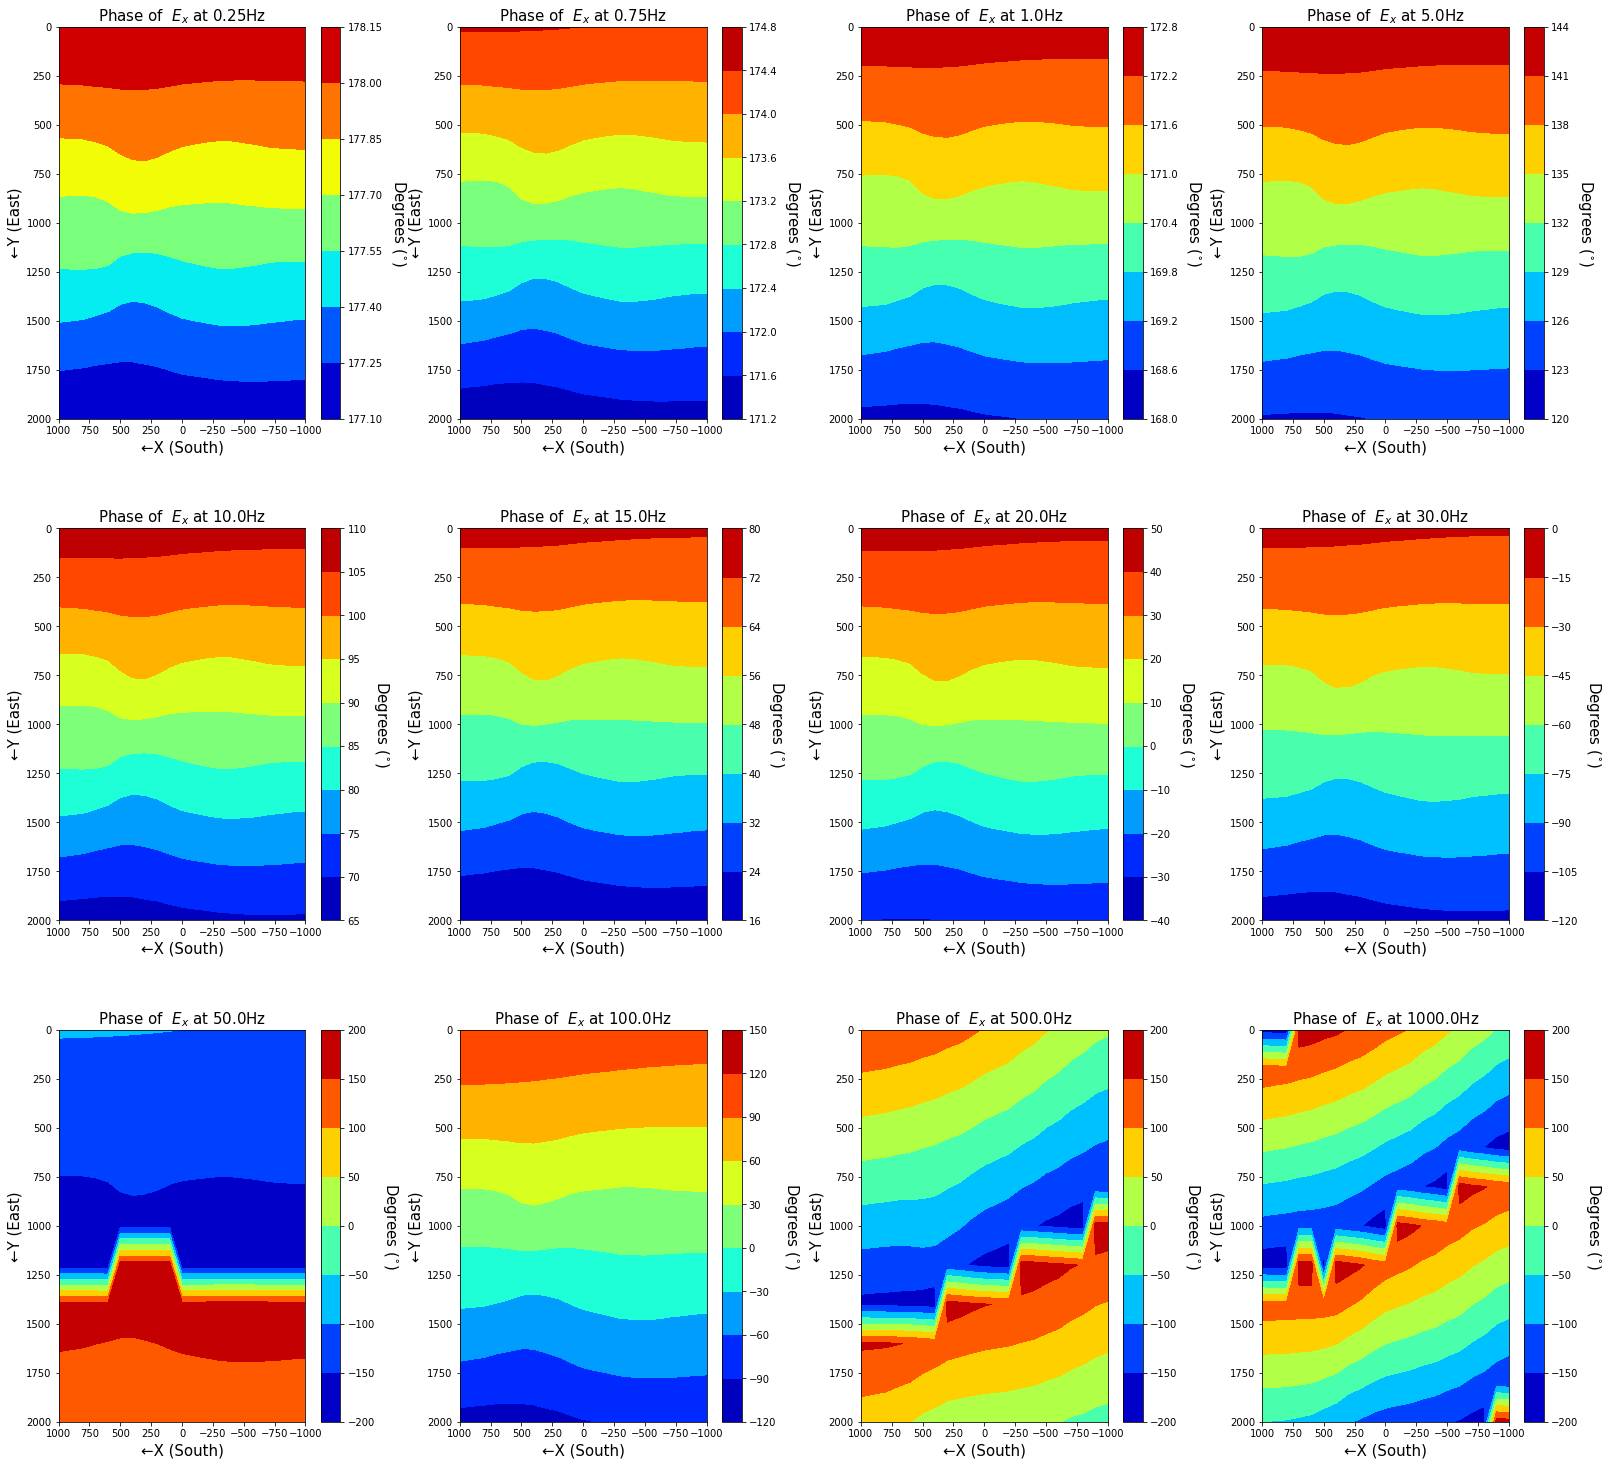

In [43]:
# Plot Data
Amp_fig = plt.figure(4, figsize=(25, 25))
for i in range(len(freq_list)):
    # Reorganize results for plotting
    e_amp_i = np.reshape(e_amp[i, :], (len(rx_loc_y), len(rx_loc_x)))
    plt.subplots_adjust(top=0.9, bottom=0.125, left=0.11, right=0.95,
                        wspace=0.3, hspace=0.28)
    # Plot results 
    Amp_plot = plt.subplot(3,4,i+1)
    Amp_plot.set_title('Amplitude of $E_{x}$ at '
                     + str(freq_list[i])
                     + 'Hz', fontsize=15)
    e_amp_plot = plt.contourf(np.flip(rx_loc_x), rx_loc_y, np.log10(e_amp_i), cmap='jet')
    Amp_plot.set_ylabel('←Y (East)', fontsize='15')
    Amp_plot.set_xlabel('←X (South)', fontsize='15')
    plt.gca().invert_yaxis()
    Amp_plot.set_xlim(np.max(rx_loc_x), np.min(rx_loc_x))
    bar_4i = plt.colorbar(e_amp_plot)
    bar_4i.set_label(label='$\log_{10}[E_{x}]$', 
                       fontsize=15, rotation=270, labelpad=25)
plt.show()

Phase_fig = plt.figure(5, figsize=(25, 25))
for j in range(len(freq_list)): 
    # Reorganize results for plotting
    e_phase_j = np.reshape(e_phase[j, :], (len(rx_loc_y), len(rx_loc_x)))
    plt.subplots_adjust(top=0.9, bottom=0.125, left=0.11, right=0.95,
                        wspace=0.3, hspace=0.28)
    # Plot results
    Phase_plot = plt.subplot(3,4,j+1)
    Phase_plot.set_title('Phase of  $E_{x}$ at ' 
                        + str(freq_list[j])
                        + 'Hz', fontsize=15)
    e_phase_plot = plt.contourf(np.flip(rx_loc_x), rx_loc_y, np.degrees(e_phase_j), cmap='jet')
    Phase_plot.set_ylabel('←Y (East)', fontsize='15')
    Phase_plot.set_xlabel('←X (South)', fontsize='15')  
    plt.gca().invert_yaxis()
    Phase_plot.set_xlim(np.max(rx_loc_x), np.min(rx_loc_x))
    bar_5j = plt.colorbar(e_phase_plot)
    bar_5j.set_label(label='Degrees ($^{\circ}$)', 
                       fontsize=15, rotation=270, labelpad=25)
plt.show()

